# **StumbleUpon Evergreen Classification**


# Setting up the environment and kaggle API

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seekerhub","key":"e38c06e3039f0b578bf75531d101e535"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [ ]:
!kaggle competitions download -c stumbleupon

  0% 0.00/8.02M [00:00<?, ?B/s]
100% 8.02M/8.02M [00:00<00:00, 72.8MB/s]
  0% 0.00/21.5k [00:00<?, ?B/s]
100% 21.5k/21.5k [00:00<00:00, 16.5MB/s]
  0% 0.00/3.45M [00:00<?, ?B/s]
100% 3.45M/3.45M [00:00<00:00, 111MB/s]
 92% 145M/157M [00:01<00:00, 95.4MB/s]
100% 157M/157M [00:01<00:00, 116MB/s] 


In [ ]:
! mkdir train
! unzip train.tsv.zip -d train

! mkdir test
! unzip test.tsv.zip -d test

Archive:  train.tsv.zip
  inflating: train/train.tsv         
Archive:  test.tsv.zip
  inflating: test/test.tsv           


# **Importing necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import string
import nltk
import warnings 
import re
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize  
from nltk.stem import WordNetLemmatizer
from matplotlib import pyplot as plt 
import numpy as np 

In [ ]:
df = pd.read_csv('/content/train/train.tsv' , sep='\t')
df.head()
df_test = pd.read_csv('/content/test/test.tsv' , sep='\t')
df_test.head(2)

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio
0,http://www.lynnskitchenadventures.com/2009/04/...,5865,"{""title"":""Homemade Enchilada Sauce Lynn s Kitc...",recreation,0.443906,2.558140,0.389706,0.257353,0.044118,0.022059,0.489572,0.0,0,0.067143,0,0.230285,0.199438,1,1,15,0,5643,136,3,0.242647,0.080597
1,http://lolpics.se/18552-stun-grenade-ar,782,"{""title"":""lolpics Stun grenade ar "",""body"":"" f...",culture_politics,0.135844,3.771429,0.461538,0.205128,0.051282,0.000000,0.782051,0.0,0,0.042857,0,0.365962,0.080000,?,1,62,0,382,39,2,0.128205,0.176471


**Visualize the Text Data**
--

Lets visualize the text data a bit using word cloud which are interactive as well as 

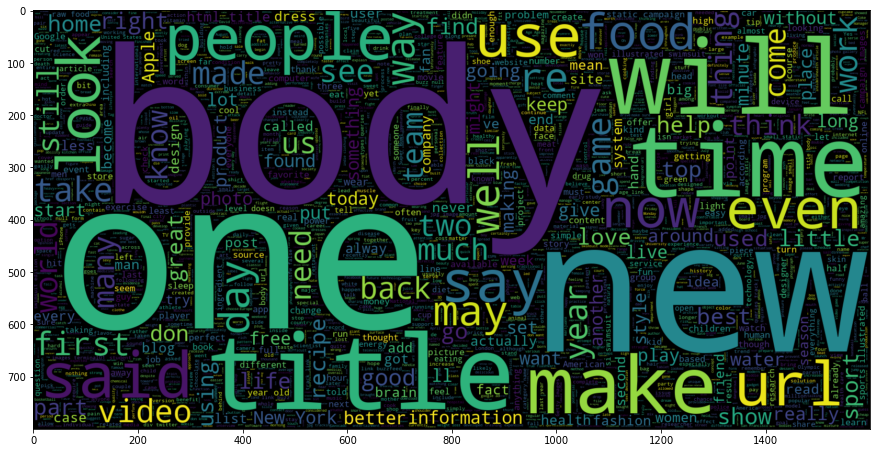

In [ ]:
plt.figure(figsize = (15,15)) # Text that are 
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.label == 0].boilerplate))
plt.imshow(wc , interpolation = 'bilinear')

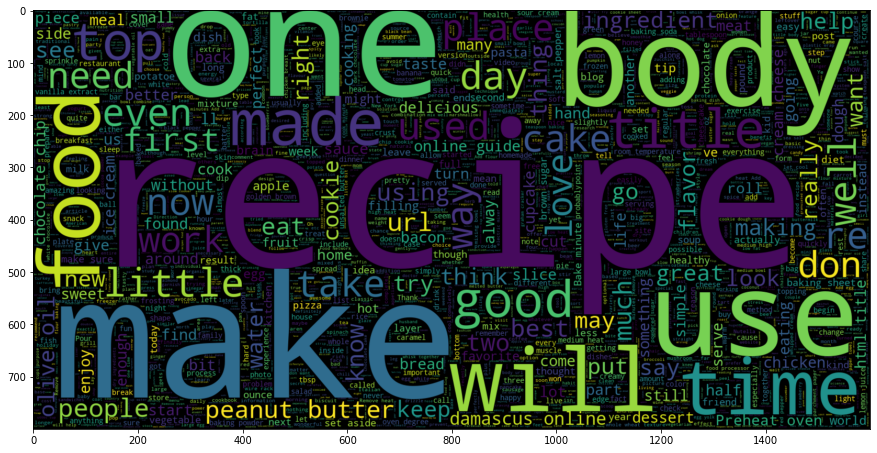

In [ ]:
from wordcloud import WordCloud

plt.figure(figsize = (15,15)) # Text that are
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.label == 1].boilerplate))
plt.imshow(wc , interpolation = 'bilinear')

**Clearly , we see that therea are so many unnecessary words which does not play a role in our analysis**

* Tags like body , url, etc which comes along with JSON 
* Words like at , the make etc 

Its important to make our text free from these words as well as punctuations etc for better evaluation.



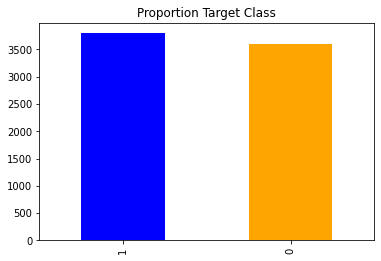

In [ ]:
count_class=pd.value_counts(df["label"], sort= True)
count_class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Proportion Target Class')
plt.show()

#**Data Preprocessing**



**Data Preprocessing Includes a few steps**
--


*   Analyzing the data for missing values and some other aspects as well
*   Handling missing Values

*   Stemming and Lemmatizing the data.
*   Tokenization





In [ ]:
df_test.isnull().sum()

url                               0
urlid                             0
boilerplate                       0
alchemy_category                  0
alchemy_category_score            0
avglinksize                       0
commonlinkratio_1                 0
commonlinkratio_2                 0
commonlinkratio_3                 0
commonlinkratio_4                 0
compression_ratio                 0
embed_ratio                       0
framebased                        0
frameTagRatio                     0
hasDomainLink                     0
html_ratio                        0
image_ratio                       0
is_news                           0
lengthyLinkDomain                 0
linkwordscore                     0
news_front_page                   0
non_markup_alphanum_characters    0
numberOfLinks                     0
numwords_in_url                   0
parametrizedLinkRatio             0
spelling_errors_ratio             0
dtype: int64

In [ ]:
df_test.isnull().sum()

url                               0
urlid                             0
boilerplate                       0
alchemy_category                  0
alchemy_category_score            0
avglinksize                       0
commonlinkratio_1                 0
commonlinkratio_2                 0
commonlinkratio_3                 0
commonlinkratio_4                 0
compression_ratio                 0
embed_ratio                       0
framebased                        0
frameTagRatio                     0
hasDomainLink                     0
html_ratio                        0
image_ratio                       0
is_news                           0
lengthyLinkDomain                 0
linkwordscore                     0
news_front_page                   0
non_markup_alphanum_characters    0
numberOfLinks                     0
numwords_in_url                   0
parametrizedLinkRatio             0
spelling_errors_ratio             0
dtype: int64

**Clearly there are no missing values and thats a good thing**

**Here we only required the boiler plate, urlid and the labels columns on which will applying further processing**

In [ ]:
train_x = df[['urlid', 'boilerplate']]
train_y = df[['label']]

In [ ]:
test_x = df_test[['urlid', 'boilerplate']]

In [ ]:
print('Training Data dimension--', train_x.shape)
print('Test Data dimension--', test_x.shape)

Training Data dimension-- (7395, 2)
Test Data dimension-- (3171, 2)


**Pre-processing the text**
---


*   First we will remove the tags such as (body ,url etc) from the boiler plate text

*   Removing unnecesary symbols like (<>, '', ! etc) and punctuations.
*   Removing emoticons if present in the text.
*   Removing unnesecary dates and numbers from the text.





In [ ]:
def preprocessor(text):
    text = re.sub('url', '', text) #Removing url tag from the text
    text = re.sub('body', '', text) #Removing body tag from the text
    text = re.sub('title', '', text) #Removing title tag from the text
    text = re.sub('<[^>]*>', '', text)
    text = re.sub("\d", " ", text)  #Removing Numbers from the text
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

In [ ]:
train_x['boilerplate'] = train_x['boilerplate'].apply(preprocessor)
train_x['boilerplate'][0]
test_x['boilerplate'] = test_x['boilerplate'].apply(preprocessor)
test_x['boilerplate']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0        homemade enchilada sauce lynn s kitchen adven...
1        lolpics stun grenade ar funny pictures at lol...
2        treadmills treadmills stair climbers treadmil...
3        father s tactics used by assad to crush revol...
4        stem turns lemons and limes into juicy atomiz...
                              ...                        
3166     peep brownie s mores busy mommy an iowa mom b...
3167     cannabissearch edibles cheesecake marijuana i...
3168     most viewed submissions all time most viewed ...
3169     how to get a complete workout with nothing bu...
3170     crispy parmesan asparagus sticks how sweet it...
Name: boilerplate, Length: 3171, dtype: object

**Handling Stopwords**
---

Stopwords are words which are meaningful for the text but does not play a role for predicting sentiments.

This include words such as (the, at, an, etc)


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))  

def removeStop(text):  
  word_tokens = word_tokenize(text)
  filtered_sentence = [w for w in word_tokens if not w in stop_words]  
  filtered_sentence = []  
  for w in word_tokens:  
      if w not in stop_words:  
          filtered_sentence.append(w)
  return filtered_sentence          

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
train_x['boilerplate'] = train_x['boilerplate'].apply(removeStop)
train_x['boilerplate']
test_x['boilerplate'] = test_x['boilerplate'].apply(removeStop)
test_x['boilerplate']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0       [homemade, enchilada, sauce, lynn, kitchen, ad...
1       [lolpics, stun, grenade, ar, funny, pictures, ...
2       [treadmills, treadmills, stair, climbers, trea...
3       [father, tactics, used, assad, crush, revolt, ...
4       [stem, turns, lemons, limes, juicy, atomizers,...
                              ...                        
3166    [peep, brownie, mores, busy, mommy, iowa, mom,...
3167    [cannabissearch, edibles, cheesecake, marijuan...
3168    [viewed, submissions, time, viewed, submission...
3169    [get, complete, workout, nothing, body, get, c...
3170    [crispy, parmesan, asparagus, sticks, sweet, w...
Name: boilerplate, Length: 3171, dtype: object

##**Applying Lemmatization**


Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meaning to one word.
 
For eg :

grouped, groups are reduced to group


**Note** : Its import to download the necesary packages froom nltk toolkit


In [ ]:
nltk.download('wordnet') 
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
  text = [lemmatizer.lemmatize(i) for i in text]
  return text


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train_x['boilerplate'] = train_x['boilerplate'].apply(lemmatize)
train_x['boilerplate']
test_x['boilerplate'] = test_x['boilerplate'].apply(lemmatize)
test_x['boilerplate']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0       [homemade, enchilada, sauce, lynn, kitchen, ad...
1       [lolpics, stun, grenade, ar, funny, picture, l...
2       [treadmill, treadmill, stair, climber, treadmi...
3       [father, tactic, used, assad, crush, revolt, t...
4       [stem, turn, lemon, lime, juicy, atomizer, gad...
                              ...                        
3166    [peep, brownie, more, busy, mommy, iowa, mom, ...
3167    [cannabissearch, edible, cheesecake, marijuana...
3168    [viewed, submission, time, viewed, submission,...
3169    [get, complete, workout, nothing, body, get, c...
3170    [crispy, parmesan, asparagus, stick, sweet, wo...
Name: boilerplate, Length: 3171, dtype: object

**Time to combined all the preprocessed data**

In [ ]:
tokenized_2 = train_x['boilerplate']
for i in range(len(tokenized_2)):
    tokenized_2[i] = ' '.join(tokenized_2[i])

train_x['boilerplate'] = tokenized_2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [ ]:
train_x['boilerplate'][99]

'worst athlete sport history worst athlete sport history beneath talented surface covering gifted world sport established crowd lacking ballplayer stats athlete made living failing completed construction hall shame time unveil finished product focused earned shot scripted proper way fail joyously exuberantly plain awfully end dude continue make headline talented peer time review made cut worst athlete sport history failure continue give hope rest u ranking list multiple sport b r swagger cool list beneath talented surface covering gifted world sport established crowd lacking ballplayer stats athlete made living failing beneath talented surface covering gifted world sport established crowd lacking ballplayer stats athlete made living failing bleacherreport article worst athlete sport history'

In [ ]:
tokenized = test_x['boilerplate']
for i in range(len(tokenized)):
    tokenized[i] = ' '.join(tokenized[i])

test_x['boilerplate'] = tokenized

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [ ]:
# df_visual = train_x.append(train_y, ignore_index=True)

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer

X_train = train_x['boilerplate']
y_train = train_y
X_test = test_x['boilerplate']
X = X_train.append(X_test, ignore_index=True)
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X)

**Splitting the data**
--


*   **Training Set**  --> Taking `80%` data here to be used for training.
*   **Validation Set**--> `20%` for the validation



In [ ]:
X_train = train_vectors[:7395,:]
X_test = train_vectors[7395:,:]

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, train_y['label'], test_size=0.2, random_state = 3)


In [ ]:
print("X_train", X_train.shape)
print("X_val", X_val.shape)
print("y_train", y_train.shape)
print("y_val", y_val.shape)


X_train (5916, 89878)
X_val (1479, 89878)
y_train (5916,)
y_val (1479,)


In [ ]:
X_test.shape

(3171, 95814)

#**Model Building and Prediction**




##Tested on two models namely :


*   **Multinomial Naive Bayes**
*   **Support Vector Machines**



**Multinomial Naive Baye's**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
pred_nb = nb.predict(X_val)

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
print(confusion_matrix(y_val, pred_nb))
print('Precision :',precision_score(y_val, pred_nb))
print('Recall Score :', recall_score(y_val, pred_nb))
print('Accuracy',accuracy_score(y_val,pred_nb))

[[577 152]
 [130 620]]
Precision : 0.8031088082901554
Recall Score : 0.8266666666666667
Accuracy 0.8093306288032455


**Support Vector Machines**



In [ ]:
from sklearn import svm
from sklearn.metrics import classification_report# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(X_train, y_train)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
pred_svm = classifier_linear.predict(X_val)
from sklearn.metrics import confusion_matrix, precision_score, recall_score
print(confusion_matrix(y_val, pred_svm))
print('Precision :',precision_score(y_val, pred_svm))
print('Recall Score :', recall_score(y_val, pred_svm))
print('Accuracy',accuracy_score(y_val,pred_svm))

[[629 100]
 [171 579]]
Precision : 0.8527245949926362
Recall Score : 0.772
Accuracy 0.8167680865449628


**Conclusion**
---
Clearly SVM shows us most promising results with the following quantites as follows:

* "Evergreen" value will be the main parameter in calculating Recall and Precision, since we will analyze whether the site is  worth marking or not.

* From the result above, we get the value of Accuracy around in `0.82` which means that we have around` 82%` level of confidence that the model was accurate.

* And we have the Recall value around in `0.77` which means that we have `77%` "Evergreen" review which predicted correctly.

* And we have the Precision value around in `0.85` which means that we have `85%` "Evergreen" review from predicted positive value which actually positive.

**Submission for Kaggle**

In [ ]:
predictions_svm = classifier_linear.predict(X_test)

In [ ]:
sub = pd.read_csv('/content/sampleSubmission.csv')
sub.head(5)

,urlid,label
0,5865,0
1,782,0
2,6962,0
3,7640,0
4,3589,0


In [ ]:
sub['label']= predictions_svm
sub['urlid']=test_x['urlid']
pd.DataFrame(sub, columns=['urlid','label']).to_csv('svm_trial.csv', index=False)

In [ ]:
testu = pd.read_csv('/content/svm_trial.csv')
testu.head(4)

,urlid,label
0,5865,1
1,782,0
2,6962,0
3,7640,0


**Result After Submission**

After submit the file i got a score of 80.1 public score and 80 private score

#**THANK YOU**